# EXERCISES FOR: 01. Neural Network Regression with TensorFlow

## 🛠 Exercises

1. Create your own regression dataset (or make the one we created in "Create data to view and fit" bigger) and build fit a model to it.
2. Try building a neural network with 4 Dense layers and fitting it to your own regression dataset, how does it perform?
3. Try and improve the results we got on the insurance dataset, some things you might want to try include:
  * Building a larger model (how does one with 4 dense layers go?).
  * Increasing the number of units in each layer.
  * Lookup the documentation of [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) and find out what the first parameter is, what happens if you increase it by 10x?
  * What happens if you train for longer (say 300 epochs instead of 200)? 
4. Import the [Boston pricing dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing/load_data) from TensorFlow [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) and model it.


### Preliminary

In [1]:
# Create timestamp
import datetime

print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-09-18 08:10:46.885445


In [2]:
# Import TensorFlow
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print(tf.__version__) # find the version number (should be 2.x+)
print(tf.config.list_physical_devices('GPU'))

2024-09-18 08:10:47.154019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 08:10:47.154045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 08:10:47.154701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Exercises
#### [1] Create humidity and pressure dataset

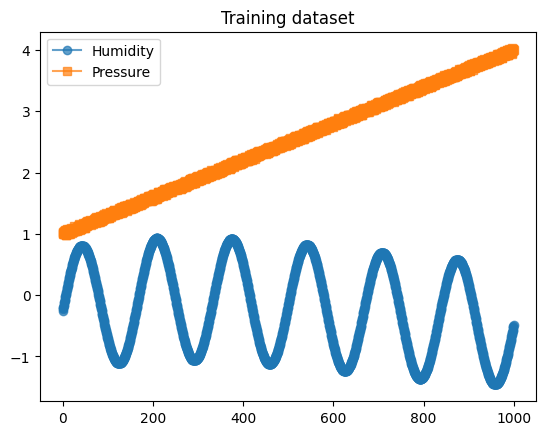

In [3]:
import numpy as np
# Time vector, in days:
time_max = 1000 # days
time = tf.constant(np.arange(0,time_max,0.5),dtype=tf.float32) # days

# Build the humidity function, in arb. units:
def build_hum(time,time_max,base,lin,cub,exp,per,ran):
    np.random.seed(0)
    hum_lin = time*lin/time_max # Linear change
    hum_cub = ((time-time_max/2)/time_max)**3*cub # Cubic change
    hum_exp = -np.exp(time/time_max)*exp # Exponential change
    hum_per = np.sin(time/time_max*12*np.pi)*per # Periodical change
    hum_ran = np.random.random(len(time))*ran-ran/2 # Random change
    hum = base + hum_lin + hum_cub + hum_exp + hum_per + hum_ran
    return tf.constant(hum,dtype=tf.float32)

base_h = 1
lin_h = 1
cub_h = 2
exp_h = 1
per_h = 1
ran_h = 0

humidity = build_hum(time,time_max,base_h,lin_h,cub_h,exp_h,per_h,ran_h) # [%]

# Build the pressure function, in arb. units:
def build_pre(time,time_max,base,lin,ran):
    np.random.seed(0)
    pres = base+time/time_max*lin + np.random.random(len(time))*ran-ran/2
    return tf.constant(pres,dtype=tf.float32)

base_p = 1
lin_p = 3
ran_p = 0.1
pressure = build_pre(time,time_max,base_p,lin_p,ran_p)

import matplotlib.pyplot as plt
# Plot:
plt.plot(time,humidity,'-o',label='Humidity',alpha=0.7)
plt.plot(time,pressure,'-s',label='Pressure',alpha=0.7)
plt.legend()
plt.title('Training dataset')
plt.show()

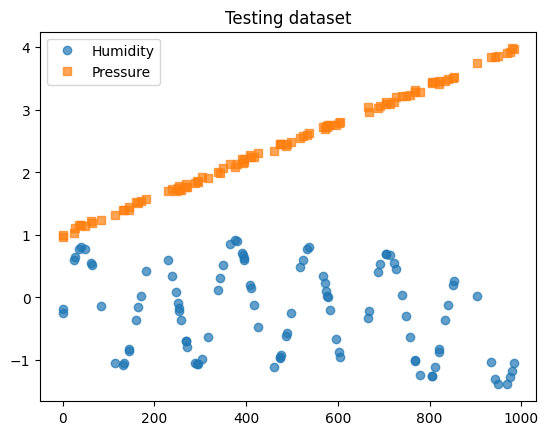

In [4]:
# Define test datasets:
time_test = tf.constant(np.random.random(100)*time_max,dtype=tf.float32)
humidity_test = build_hum(time_test,time_max,base_h,lin_h,cub_h,exp_h,per_h,ran_h) # [%]
pressure_test = build_pre(time_test,time_max,base_p,lin_p,ran_p)

# Plot:
plt.plot(time_test,humidity_test,'o',label='Humidity',alpha=0.7)
plt.plot(time_test,pressure_test,'s',label='Pressure',alpha=0.7)
plt.legend()
plt.title('Testing dataset')
plt.show()

#### [1,2,3] Build ML models

I0000 00:00:1726611049.622290   25741 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               1024      
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 428033 (1.63 MB)
Trainable params: 428033 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential

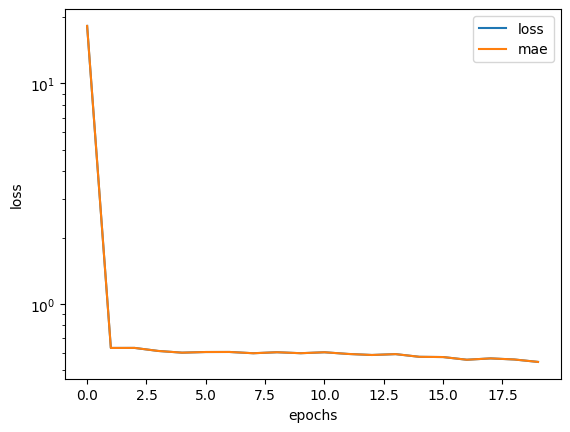

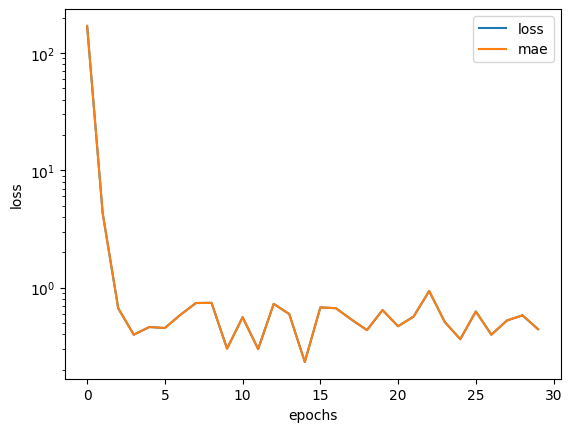

In [5]:
# Set random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
model_pres = tf.keras.Sequential([
    # tf.keras.layers.Dense(20,activation='relu'),
    tf.keras.layers.Dense(1, input_shape=[1])
])

model_hum = tf.keras.Sequential([
    tf.keras.layers.Dense(512,activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1)
])

import pandas as pd

def compile_train_model(model,loss,optimizer,metrics,X_train,Y_train,epochs,exp_dims=True):
    # Compile the model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=metrics)
    # Train the model:
    if exp_dims:
        history = model.fit(tf.expand_dims(X_train, axis=-1), Y_train, epochs=epochs, verbose=0)
    else:
        history = model.fit(X_train, Y_train, epochs=epochs, verbose=0)

    return history

# Prepare models:
X_train = time
# Humidity model:
history_hum = compile_train_model(model_hum,
                    tf.keras.losses.mae, # Loss function
                    tf.keras.optimizers.Adam(learning_rate=0.01), # Optimizer
                    ["mae"], # Metrics
                    X_train,humidity, # Data
                    20) # Epochs
# Check the model summary
model_hum.summary()
# Plot training history:
pd.DataFrame(history_hum.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: epochs will only show 100 since we overrid the history variable
plt.yscale('log');

# Pressure model: 
history_pres = compile_train_model(model_pres,
                    tf.keras.losses.mae,
                    tf.keras.optimizers.Adam(learning_rate=0.01),
                    ["mae"],
                    X_train,pressure,
                    30)
# Check the model summary
model_pres.summary()
# Plot training history:
pd.DataFrame(history_pres.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs") # note: epochs will only show 100 since we overrid the history variable
plt.yscale('log');

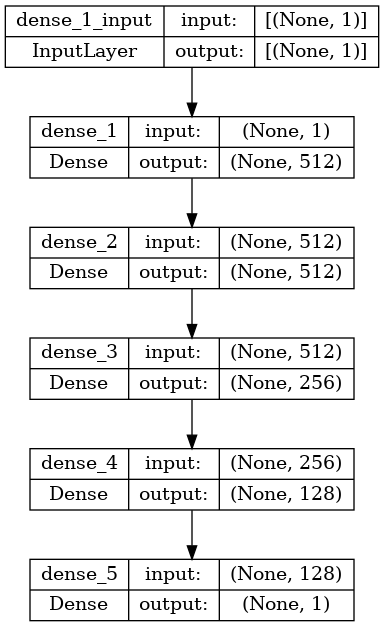

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model_hum, show_shapes=True)

4/4 [==============================] - 0s 994us/step


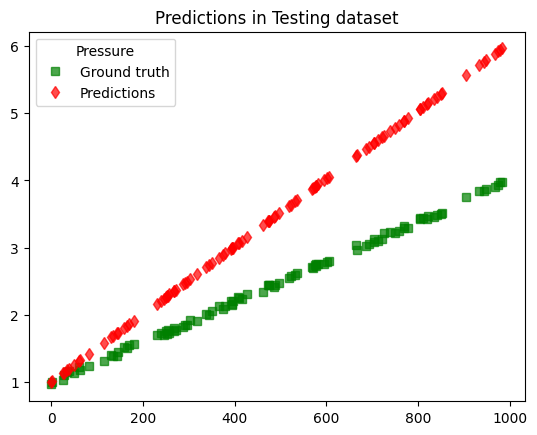

4/4 [==============================] - 0s 6ms/step


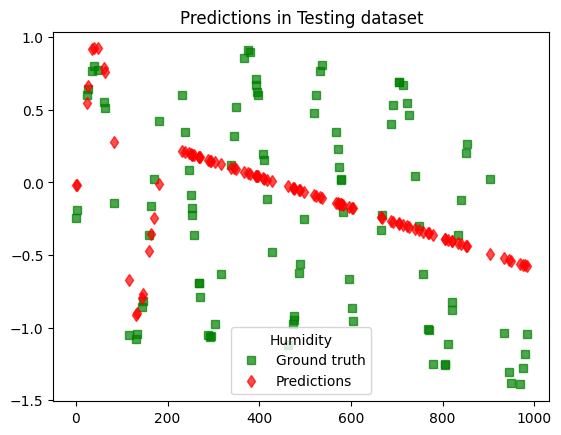

In [7]:
def predict_evaluate_plot(model,X_test,Y_test,title=None):
    # Predict:
    Y_pred = model.predict(X_test)
    # Plot predictions and ground truth:
    plt.plot(X_test,Y_test,'s',label='Ground truth',color='green',alpha=0.7)
    plt.plot(X_test,Y_pred,'d',label='Predictions',color='red',alpha=0.7)
    plt.legend(title=title)
    plt.title('Predictions in Testing dataset')
    plt.show()

# Pressure model:
predict_evaluate_plot(model_pres,time_test,pressure_test,title='Pressure')
# Humidity model:
predict_evaluate_plot(model_hum,time_test,humidity_test,title='Humidity')

#### [4] Work with the Boston house pricing dataset 

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)

In [9]:
# Check data shape:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((404, 13), (404,), (102, 13), (102,))

In [10]:
# Convert to tensors:
x_train_tf = tf.constant(x_train)
y_train_tf = tf.constant(y_train)
x_test_tf = tf.constant(x_test)
y_test_tf = tf.constant(y_test)
# Check data shape:
x_train_tf.shape, y_train_tf.shape, x_test_tf.shape, y_test_tf.shape

(TensorShape([404, 13]),
 TensorShape([404]),
 TensorShape([102, 13]),
 TensorShape([102]))

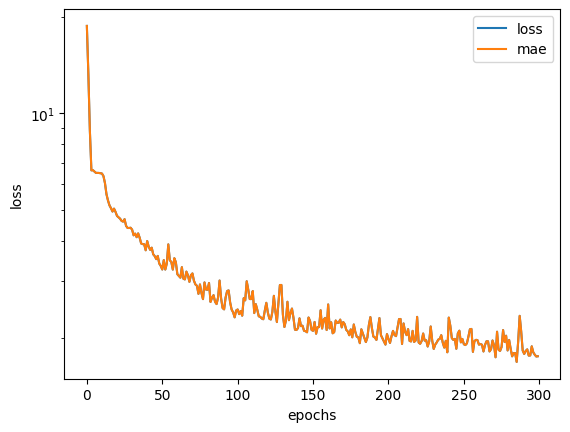

Mean Absolute Error: 3.421990641425638


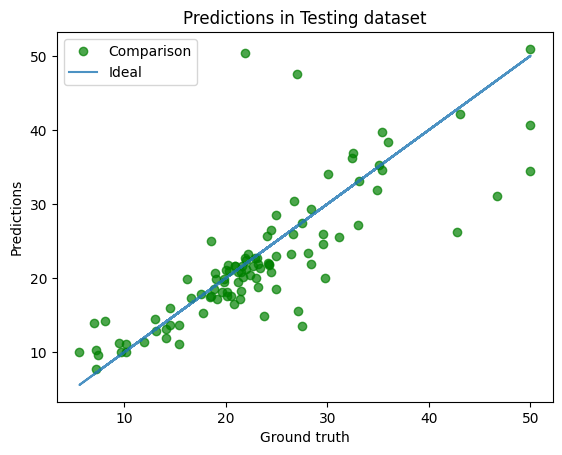

In [47]:
# Build models:
# Set random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
activ_1='tanh'
activ_2='relu'
activ_3='sigmoid'
model_boston = tf.keras.Sequential([
    tf.keras.layers.Dense(256,activation=activ_3, input_shape=x_train_tf[0].shape),
    tf.keras.layers.Dense(128,activation=activ_3),
    tf.keras.layers.Dense(64,activation=activ_1),
    tf.keras.layers.Dense(64,activation=activ_2),
    tf.keras.layers.Dense(1)
])
history = compile_train_model(model_boston,
                    tf.keras.losses.mae, # Loss function
                    tf.keras.optimizers.Adam(learning_rate=0.001), # Optimizer
                    ["mae"], # Metrics
                    x_train_tf,y_train_tf, # Data
                    300, # Epochs
                    exp_dims=False) 
# Plot training history:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs") # note: epochs will only show 100 since we overrid the history variable
plt.yscale('log')
plt.show();

# Predict:
y_pred = model_boston.predict(x_test_tf,verbose=0).squeeze()
#Evaluate:
mae = tf.reduce_mean(tf.abs(y_test_tf-y_pred.squeeze())).numpy()
print('Mean Absolute Error:', mae)
# Plot predictions and ground truth:
plt.plot(y_test_tf,y_pred,'o',label='Comparison',color='green',alpha=0.7)
plt.plot(y_test_tf,y_test_tf,'-',label='Ideal',alpha=0.8)
#plt.plot(y_pred,'d',label='Predictions',color='red',alpha=0.7)
plt.legend()
plt.xlabel('Ground truth'), plt.ylabel('Predictions')
plt.title('Predictions in Testing dataset');

## 📖 Extra curriculum

If you're looking for extra materials relating to this notebook, I'd check out the following:

* [MIT introduction deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) - gives a great overview of what's happening behind all of the code we're running.
* Reading: 1-hour of [Chapter 1 of Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielson - a great in-depth and hands-on example of the intuition behind neural networks.

To practice your regression modelling with TensorFlow, I'd also encourage you to look through [Lion Bridge's collection of datasets](https://lionbridge.ai/datasets/) or [Kaggle's datasets](https://www.kaggle.com/data), find a regression dataset which sparks your interest and try to model.